In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Index
df = pd.read_csv('apple_stock_data.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Choose feature to predict
series = df[['close']].values # (N, 1)

# Scale to 0-1
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

In [2]:
# turn 1D series to supervised sequences

def make_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window]) #next-day Close
    return np.array(X), np.array(y)

WINDOW = 10 # 10 days of history
X, y = make_sequences(series_scaled, WINDOW)

In [3]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a model with high dropout and small LR
def build_model(dropout=0.5, lr=5e-4):
    model = Sequential(
        [
            LSTM(50, input_shape=(WINDOW, 1), return_sequences=False),
            Dropout(dropout),
            Dense(1),
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
    )

    return model



In [25]:
from sklearn.model_selection import TimeSeriesSplit

# Prepare early stop
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
)

# TimeSeriesSplit CV to get stable val_loss
tscv = TimeSeriesSplit(n_splits=5)
val_losses = []

for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    model_cv = build_model(dropout=0.3, lr=1e-4)
    history_cv = model_cv.fit(
        X_train_cv,
        y_train_cv,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[early_stop],
        verbose=0,
    )
    best_val = min(history_cv.history['val_loss'])
    print(f"Fold {fold} - Best val_loss: {best_val:.4f}")
    val_losses.append(best_val)

print(f"\nAverage CV val_loss: {np.mean(val_losses):.6f}  ± {np.std(val_losses):.6f}")

Fold 0 - Best val_loss: 0.0010
Fold 1 - Best val_loss: 0.0011
Fold 2 - Best val_loss: 0.0009
Fold 3 - Best val_loss: 0.0008
Fold 4 - Best val_loss: 0.0027

Average CV val_loss: 0.001300  ± 0.000695


In [35]:
final_model = build_model(dropout=0.3, lr=1e-4)
final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    validation_data=(X_test, y_test),
    shuffle=False,
    verbose=2
)

Epoch 1/100
33/33 - 4s - loss: 0.1384 - val_loss: 0.3782 - 4s/epoch - 118ms/step
Epoch 2/100
33/33 - 0s - loss: 0.0806 - val_loss: 0.2328 - 273ms/epoch - 8ms/step
Epoch 3/100
33/33 - 0s - loss: 0.0414 - val_loss: 0.1205 - 275ms/epoch - 8ms/step
Epoch 4/100
33/33 - 0s - loss: 0.0174 - val_loss: 0.0480 - 282ms/epoch - 9ms/step
Epoch 5/100
33/33 - 0s - loss: 0.0079 - val_loss: 0.0179 - 281ms/epoch - 9ms/step
Epoch 6/100
33/33 - 0s - loss: 0.0063 - val_loss: 0.0111 - 278ms/epoch - 8ms/step
Epoch 7/100
33/33 - 0s - loss: 0.0067 - val_loss: 0.0098 - 283ms/epoch - 9ms/step
Epoch 8/100
33/33 - 0s - loss: 0.0074 - val_loss: 0.0108 - 278ms/epoch - 8ms/step
Epoch 9/100
33/33 - 0s - loss: 0.0064 - val_loss: 0.0087 - 276ms/epoch - 8ms/step
Epoch 10/100
33/33 - 0s - loss: 0.0066 - val_loss: 0.0069 - 283ms/epoch - 9ms/step
Epoch 11/100
33/33 - 0s - loss: 0.0066 - val_loss: 0.0063 - 365ms/epoch - 11ms/step
Epoch 12/100
33/33 - 0s - loss: 0.0064 - val_loss: 0.0069 - 291ms/epoch - 9ms/step
Epoch 13/100


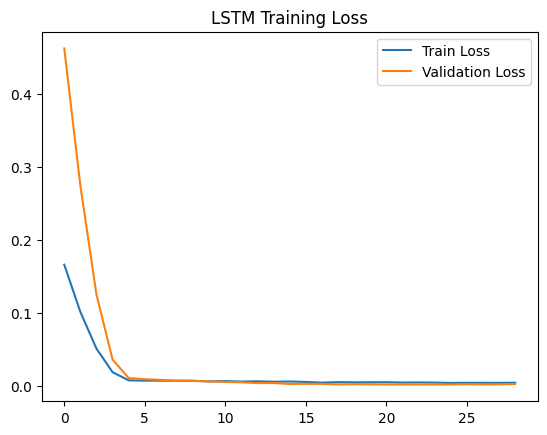

8/8 [==============================] - 1s 4ms/step


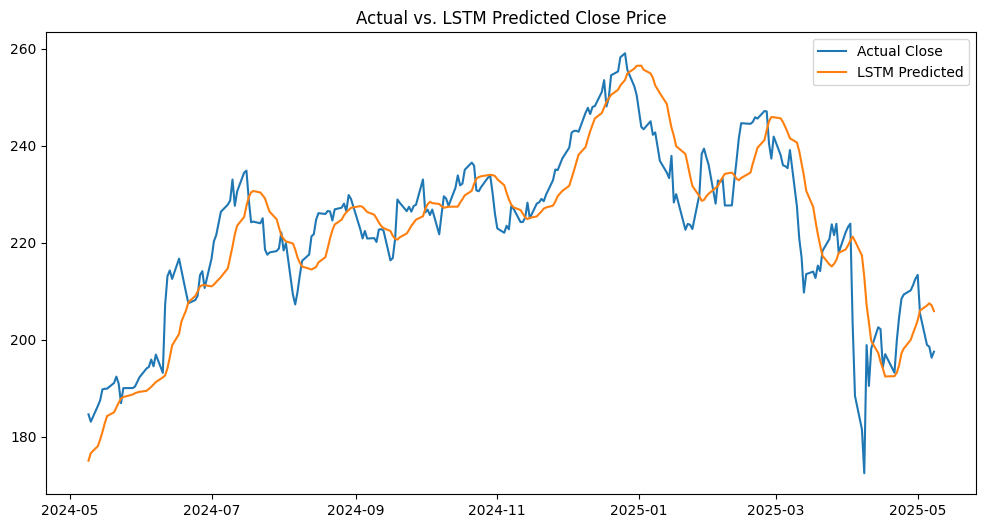

In [36]:
# Evaluate

# Plot train vs val loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training Loss")
plt.show()

# Predict & invert scale
y_pred_scaled = final_model.predict(X_test)
# If y_pred_scaled has shape (num_samples, window, 1), take only the last time step
if y_pred_scaled.ndim == 3:
	y_pred_scaled = y_pred_scaled[:, -1, 0]
elif y_pred_scaled.ndim == 2:
	y_pred_scaled = y_pred_scaled[:, -1]
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# Plot actual vs. predicted
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_true, label='Actual Close')
plt.plot(df.index[-len(y_test):], y_pred, label='LSTM Predicted')
plt.legend()
plt.title("Actual vs. LSTM Predicted Close Price")
plt.show()

In [38]:
import numpy as np
# final val_loss is history.history['val_loss'][-1]
scaled_mse = history.history['val_loss'][-1]
scaled_rmse = np.sqrt(scaled_mse)
# if you used MinMaxScaler or similar, invert:
real_rmse = scaled_rmse * (df['close'].max() - df['close'].min())
print(f"Approx. real‐world RMSE: ${real_rmse:.2f}")


Approx. real‐world RMSE: $9.88
